In [ ]:
!gdown https://drive.google.com/uc?id=19fBCItau0MP1ABKlBNkpj1pMxOzIZLML&export=download
!gdown https://drive.google.com/uc?id=1X7TLVCvi2a57SyjAdExPppzakxfenRD0&export=download
!unzip train.zip -d train
!unzip test.zip -d test

In [ ]:
!pip install -U catalyst albumentations

In [2]:
import numpy as np
from pathlib import Path
import pandas as pd

import torch
import torch.nn as nn
from torch.utils import data

import catalyst
from catalyst import dl
from catalyst.utils import metrics, imread, set_global_seed
import torchvision

In [3]:
set_global_seed(42)
train_image_path = Path("train") / "images"
train_mask_path = Path("train") / "masks"
ALL_IMAGES = sorted(train_image_path.glob("*.png"))
ALL_MASKS = sorted(train_mask_path.glob("*.png"))
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, images=None, masks=None, transforms=None) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = imread(image_path)

        result = {"image": image}

        if self.masks is not None:
            result["mask"] = imread(self.masks[idx]).mean(2) // 255

        if self.transforms is not None:
            result = self.transforms(**result)
            if result.get("mask", None) is not None:
                result["mask"] = result["mask"].unsqueeze(0)

        result["filename"] = image_path.name
        result["image size"] = image.shape[:2]

        return result

In [ ]:
#! pip install albumentations==0.4.6

In [4]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2 as ToTensor
import cv2

IMAGE_SIZE = 256
train_transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.Resize(IMAGE_SIZE, IMAGE_SIZE),
    albu.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE, p=0.3),
    albu.Normalize(),
    ToTensor()
])

valid_transform = albu.Compose([
    albu.Resize(IMAGE_SIZE, IMAGE_SIZE),
    albu.Normalize(),
    ToTensor()
])

In [79]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

batch_size = 20
num_workers = 4

indices = np.arange(len(ALL_IMAGES))

train_indices, valid_indices = train_test_split(
    indices, test_size=0.25, random_state=42, shuffle=True
)

np_images = np.array(ALL_IMAGES)
np_masks = np.array(ALL_MASKS)

train_dataset = SegmentationDataset(
    images = np_images[train_indices].tolist(),
    masks = np_masks[train_indices].tolist(),
    transforms = train_transform
)

valid_dataset = SegmentationDataset(
    images = np_images[valid_indices].tolist(),
    masks = np_masks[valid_indices].tolist(),
    transforms = valid_transform
)

loaders = {
    "train": DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=True,
    ),
    "valid": DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=True,
    )
}

In [ ]:
!pip install pretrainedmodels==0.7.4
!pip install segmentation_models_pytorch

In [10]:
import segmentation_models_pytorch as smp

In [12]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1,
    activation='sigmoid'
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [13]:
from catalyst.contrib.nn import DiceLoss, IoULoss
from catalyst.dl.runner import SupervisedRunner
from torch.nn.functional import interpolate


class SegmentationRunner(SupervisedRunner):
    def predict_batch(self, batch):
        prediction = {"filename": batch["filename"]}
        masks = self.model(batch[self.input_key].to(self.device))
        image_size = list(zip(*batch["image size"]))
        prediction["mask"] = [
            interpolate(mask.unsqueeze(0), image_size).squeeze(0)
            for mask, image_size in zip(masks, image_size)
        ]
        return prediction

criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0005)

runner = SegmentationRunner(input_key="image", input_target_key="mask")

In [14]:
callbacks = [
    dl.CriterionCallback(
        input_key="mask", prefix="loss_dice", criterion_key="dice"
    ),
    dl.CriterionCallback(
        input_key="mask", prefix="loss_iou", criterion_key="iou"
    ),
    dl.CriterionCallback(
        input_key="mask", prefix="loss_bce", criterion_key="bce"
    ),
    dl.MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum",
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),
    dl.DiceCallback(input_key="mask"),
    dl.IouCallback(input_key="mask"),
]

In [18]:
from datetime import datetime
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=callbacks,
    logdir=Path("/content/drive/My Drive/flowers_segm/logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=50,
    main_metric="iou",
    minimize_metric=False,
    verbose=True,
)

1/50 * Epoch (train):   0% 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/catalyst/core/callbacks/optimizer.py:137: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)



1/50 * Epoch (train): 100% 17/17 [12:17<00:00, 43.38s/it, dice=0.528, iou=0.359, loss=1.605, loss_bce=0.615, loss_dice=0.472, loss_iou=0.641]
1/50 * Epoch (valid): 100% 3/3 [00:40<00:00, 13.46s/it, dice=0.451, iou=0.291, loss=2.043, loss_bce=0.982, loss_dice=0.549, loss_iou=0.709]
[2020-10-09 07:05:30,538] 
1/50 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/50 * Epoch 1 (train): dice=0.4750 | iou=0.3133 | loss=1.7466 | loss_bce=0.6687 | loss_dice=0.5250 | loss_iou=0.6867
1/50 * Epoch 1 (valid): dice=0.4194 | iou=0.2657 | loss=2.1268 | loss_bce=1.0149 | loss_dice=0.5806 | loss_iou=0.7343
2/50 * Epoch (train): 100% 17/17 [13:35<00:00, 47.99s/it, dice=0.432, iou=0.275, loss=1.818, loss_bce=0.657, loss_dice=0.568, loss_iou=0.725]
2/50 * Epoch (valid): 100% 3/3 [00:46<00:00, 15.61s/it, dice=0.491, iou=0.325, loss=1.706, loss_bce=0.651, loss_dice=0.509, loss_iou=0.675]
[2020-10-09 07:20:13,524] 
2/50 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/50 * Epoch 2 (train): dice=0.4945 | iou=

In [80]:
submission = {"masks": []}
for prediction in runner.predict_loader(loader=loaders['valid']):
    submission["masks"].extend(mask
        for mask in prediction["mask"]
    )

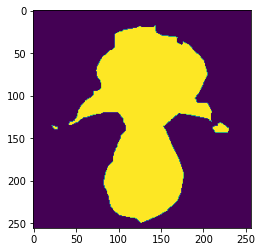

In [73]:
for res in loaders['valid']:
  plt.imshow(res['mask'][0][0])

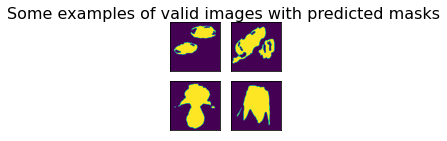

In [81]:
itere=iter(loaders['valid'])
fig = plt.figure(figsize=(2, 2))
fig.suptitle("Some examples of valid images with predicted masks", fontsize=16)
for i in range(4):
    res = next(itere)
    plt.subplot(2, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(res['mask'][0][0])
plt.show()